# 2+1D Mixture Density RNN Sample Data Experiment

- This script shows how RoboJam's MDRNN can be used to model 3D data.
- First, we generate some synthetic data for the experiment.
- Next, we train the MDRNN on the dat
- Finally, generate some unconditional output and have a look.

### Generate Synthetic Data

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# little path hack to get robojam from one directory up in the filesystem.
from context import * # imports robojam
# import robojam # alternatively do this.
import tensorflow as tf

In [2]:
# data:
x_y_t_log = robojam.generate_synthetic_3D_data()
loader = robojam.SequenceDataLoader(num_steps=65, batch_size=64, corpus=x_y_t_log)

Generating 50000 toy data samples.
                  a             b             t
count  50000.000000  50000.000000  50000.000000
mean       0.499711      0.499627      0.099998
std        0.357275      0.357466      0.007054
min       -0.173210     -0.178889      0.000100
25%        0.149328      0.148592      0.095209
50%        0.499224      0.499204      0.100000
75%        0.849420      0.850883      0.104759
max        1.168818      1.172700      0.132862
Total training examples: 49934
Done initialising loader.


### Plotting functions

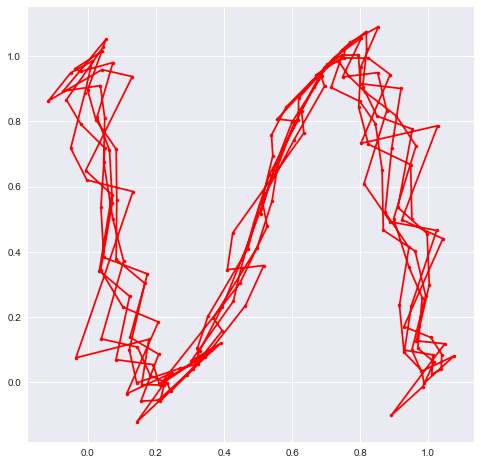

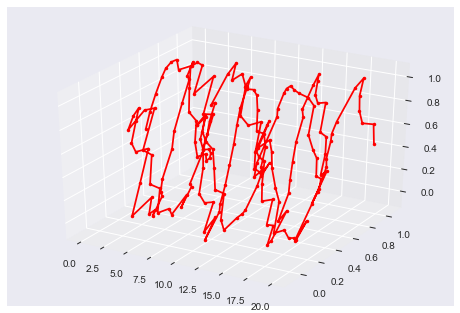

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns

def plot_3D_data(perf):
    """Plot in 3D."""
    perf = perf.T
    perf_df = pd.DataFrame({'x':perf[0], 'y':perf[1], 't':perf[2]})
    perf_df['time'] = perf_df.t.cumsum()
    # Plot in 2D
    plt.figure(figsize=(8, 8))
    p = plt.plot(perf_df.x, perf_df.y, '.r-')
    plt.show()
    # Plot in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(perf_df.time, perf_df.x, perf_df.y, '.r-')
    plt.show()
    
# Plot the sample data
plot_3D_data(x_y_t_log[:200])

### Train the network

In [5]:
# Hyperparameters
H_UNITS = 128
N_MIX = 8
BATCH = 64
SEQ_LEN = 64
# Setup network
net = robojam.MixtureRNN(mode=robojam.NET_MODE_TRAIN, n_hidden_units=H_UNITS, n_mixtures=N_MIX, batch_size=BATCH, sequence_length=SEQ_LEN)

INFO:tensorflow:Loading Training Operations
INFO:tensorflow:done initialising: mdrnn-2d-1d-1layers-128units-8mixtures vars: 76872


In [6]:
# Train
# 1 epoch is too few, about 30 works well.
losses = net.train(loader, 1, saving=True)

INFO:tensorflow:going to train: mdrnn-2d-1d-1layers-128units-8mixtures
INFO:tensorflow:trained epoch 0 of 1
INFO:tensorflow:saving model mdrnn-2d-1d-1layers-128units-8mixtures.
INFO:tensorflow:took 84 seconds to train.


### Test the network by generating some data

In [9]:
first_touch = np.array([(np.random.rand()-0.5), (np.random.rand()-0.5), (0.01 + (np.random.rand()-0.5)*0.005)])
print("Test Input:",first_touch)
# Load running network.
net = robojam.MixtureRNN(mode=robojam.NET_MODE_RUN, n_hidden_units=128, n_mixtures=8, batch_size=1, sequence_length=1)
with tf.Session() as sess:
    perf = net.generate_performance(first_touch,1000,sess)
print("Test Output:")
perf_df = pd.DataFrame({'a':perf.T[0], 'b':perf.T[1], 't':perf.T[2]})
perf_df['time'] = perf_df.t.cumsum()
print(perf_df.describe())

Test Input: [-0.00035605  0.13900439  0.01140421]
INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: mdrnn-2d-1d-1layers-128units-8mixtures vars: 76872
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-1layers-128units-8mixtures
Test Output:
                 a            b            t         time
count  1001.000000  1001.000000  1001.000000  1001.000000
mean      0.404527     0.448566     0.098029    41.117687
std       0.309990     0.348629     0.230025    32.613132
min      -4.556438    -3.718370    -2.545966   -10.836983
25%       0.360380     0.413010     0.110550    12.009743
50%       0.433711     0.481972     0.114826    40.704260
75%       0.498861     0.557843     0.119179    69.324225
max       2.295657     2.170020     2.509095    98.127245


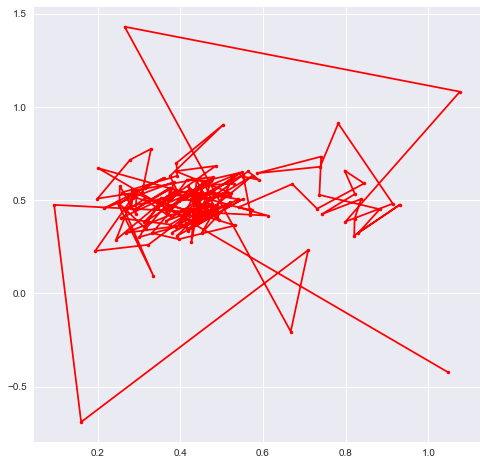

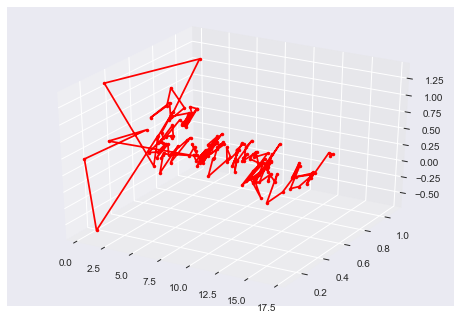

In [10]:
# plots
plot_3D_data(perf[50:200])